In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from itertools import combinations
import json
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
df = pd.read_csv('/content/drive/MyDrive/initial/notebook/marketing.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2010 non-null   int64  
 1   Age                  2010 non-null   int64  
 2   Gender               2010 non-null   object 
 3   Income               1931 non-null   float64
 4   CampaignChannel      1856 non-null   object 
 5   CampaignType         2010 non-null   object 
 6   AdSpend              2010 non-null   object 
 7   ClickThroughRate     2010 non-null   float64
 8   ConversionRate       2010 non-null   float64
 9   WebsiteVisits        2010 non-null   int64  
 10  PagesPerVisit        2010 non-null   float64
 11  TimeOnSite           1931 non-null   float64
 12  SocialShares         2010 non-null   int64  
 13  EmailOpens           2010 non-null   int64  
 14  EmailClicks          2010 non-null   int64  
 15  PreviousPurchases    2010 non-null   i

My data columns:

WebsiteVisits: (numeric)

PagesPerVisit: (numeric)

TimeOnSite: (numeric)

<H1>Functions

In [5]:
def describe_numerical_col(df, col_name):
    info = df[[col_name]].describe().to_dict()[col_name]
    info['shapiro'] = f'{stats.shapiro(df[col_name])[1]: .5f}'
    info['normal'] = float(info['shapiro']) > 0.05
    info['missing'] = df[col_name].isna().sum()
    info['skew'] = f'{stats.skew(df[col_name]):.5f}'
    info['type'] = ('slight ' if info['normal'] else '') +\
        ('right(positive)' if float(info['skew']) > 0 else 'left(negative)') + '-skew'

    fig, ax = plt.subplots(2, 2, figsize=(16, 7), gridspec_kw={'height_ratios':(.85, .15)})
    sns.histplot(df[col_name], kde=True, ax=ax[0, 0], color='#55A868')
    sns.boxplot(df[col_name], orient='h', ax=ax[1, 0], color="#5583A8")
    counts, bin_edges = np.histogram(df[col_name], bins=10, density = True)
    pdf = counts / (sum(counts))
    cdf = np.cumsum(pdf)
    ax[1, 1] = plt.subplot(122)
    plt.plot(bin_edges[1:], pdf, label='PDF')
    plt.plot(bin_edges[1:], cdf, label='CDF')
    plt.legend()
    ax[0, 0].set_xticklabels([])
    ax[1, 0].set_yticklabels([])
    ax[0, 0].set_xlabel('')
    ax[0, 0].set_ylabel('Count')
    fig.suptitle(col_name, fontsize=30)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print('='*18 + ' ' +col_name + ' ' + '='*18)
    print(info_df)
    print('='*40)

In [6]:
def plot_numerical_vs_target(df, num_col, target_col):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # First plot: A histogram of two groups
    sns.histplot(data=df[[num_col, target_col]],
                x=num_col, hue=target_col,
                kde=True,
                ax=ax[0, 0],
                element='step',
                palette='Pastel1',
                alpha=0.7)
    ax[0, 0].set_xlabel('')
    legend = ax[0, 0].get_legend()
    handles = legend.legend_handles
    ax[0, 0].legend(handles, ['No', 'Yes'], title=target_col)

    # Second plot: Box plots of two Groups
    sns.boxplot(data = df, x=target_col, y=num_col, palette='Pastel1', ax=ax[0, 1])
    ax[0, 1].set_xticklabels([])
    ax[0, 1].set_xlabel('')
    # Third plot: Violen plot
    sns.violinplot(data=df, x=target_col, y=num_col, palette='Pastel1', ax=ax[1, 1])
    ax[1, 1].set_xticks([0, 1], ['No', 'Yes'])
    # Forth plot: Q-Q plot
    stats.probplot(df[num_col], plot=ax[1, 0])
    fig.tight_layout()
    plt.show()

In [7]:
def categorize_numerical_col(df, col_name, bins, bins_name):
    new_col = f'{col_name}_categorized'
    df[new_col] = pd.cut(df[col_name], bins=bins, labels=bins_name)
    return df

In [8]:
def describe_categorical_col(df, col_name):
    counts = pd.DataFrame(df[col_name].value_counts()).reset_index()
    counts.columns = ['Group', 'Count']
    total = sum(counts['Count'])
    counts['%'] = (counts['Count'] / total * 100).round(2)

    fig = px.pie(
        counts,
        names='Group',
        values='Count',
        title=f'<b>Distribution of {col_name} in each group</b>',
        color='Group',
        hole=0.3
    )

    fig.update_traces(
        textposition='inside',
        textinfo='percent+label',

    )

    fig.update_layout(
        title_x=0.5,
        legend_title_text='Groups',
        font=dict(family="Arial, sans-serif", size=14)
    )
    fig.show()
    print('='*18 + ' ' +col_name + ' ' + '='*18)
    print(counts)
    print('='*40)

In [9]:
def describe_num_num_relationship(df, col1, col2):
    """تحلیل رابطه بین دو متغیر عددی"""
    # آزمون نرمال بودن با شاپیرو
    shapiro1_stat, shapiro1_p = stats.shapiro(df[col1])
    shapiro2_stat, shapiro2_p = stats.shapiro(df[col2])

    # تشخیص نرمال بودن (p > 0.05 یعنی نرمال)
    is_normal1 = shapiro1_p > 0.05
    is_normal2 = shapiro2_p > 0.05
    both_normal = is_normal1 & is_normal2

    # انتخاب آزمون مناسب
    if both_normal:
        # استفاده از پیرسون
        corr_stat, p_value = stats.pearsonr(df[col1], df[col2])
        test_used = 'Pearson'
        correlation = corr_stat
    else:
        # استفاده از اسپیرمن
        corr_stat, p_value = stats.spearmanr(df[col1], df[col2])
        test_used = 'Spearman'
        correlation = corr_stat

    r2_score = correlation ** 2

    info = {
        'shapiro_p_col1': f'{shapiro1_p:.5f}',
        'shapiro_p_col2': f'{shapiro2_p:.5f}',
        'col1_normal': is_normal1,
        'col2_normal': is_normal2,
        'test_used': test_used,
        'correlation': f'{correlation:.5f}',
        'r_squared': f'{r2_score:.5f}',
        'p_value': f'{p_value:.5f}',
        'significant': p_value < 0.05,
        'relationship_strength': 'strong' if abs(correlation) > 0.7 else 'moderate' if abs(correlation) > 0.3 else 'weak',
        'relationship_direction': 'positive' if correlation > 0 else 'negative'
    }

    # رسم نمودار
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{col1} vs {col2} - {test_used} Correlation', fontsize=14)

    # Scatter Plot
    axes[0].scatter(df[col1], df[col2],
                    s=60, alpha=0.7, color='blue', edgecolors='black', linewidth=0.5)
    axes[0].set_title('Scatter Plot')
    axes[0].set_xlabel(col1)
    axes[0].set_ylabel(col2)
    axes[0].grid(True, alpha=0.3)

    # Hexbin Plot
    axes[1].hexbin(df[col1], df[col2], gridsize=20, cmap='Blues', mincnt=1)
    axes[1].set_title('Hexbin Plot')
    axes[1].set_xlabel(col1)
    axes[1].set_ylabel(col2)
    axes[1].yaxis.set_label_position("right")

    plt.tight_layout()
    plt.show()
    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print('='*15 + f' {col1} vs {col2} ' + '='*15)
    print(info_df)
    print('='*50)

In [10]:
def describe_cat_cat_relationship(df, col1, col2):
    """تحلیل رابطه بین دو متغیر کیفی"""
    # جدول تطبیقی
    contingency_table = pd.crosstab(df[col1], df[col2])
    normalized = pd.crosstab(df[col1], df[col2], normalize='index')

    # رسم نمودار
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Heatmap of contingency table
    sns.heatmap(contingency_table, annot=True, cbar=False ,fmt='d', cmap=['White'], ax=axs[0, 0], linecolor='lightgray', linewidths=0.7)
    axs[0, 0].set_title(f'Contingency Table: {col1} vs {col2}')

    # Stacked bar chart 100%
    normalized.plot.bar(stacked=True, ax=axs[0, 1])
    axs[0, 1].set_title(f'Stacked Bar: {col1} vs {col2}')
    axs[0, 1].legend(title=col2, labels=['No', 'Yes'])
    plt.xticks(rotation=45)

    # Normalized heatmap (percentages)
    sns.heatmap(normalized, annot=True, fmt='.2%', cbar=False, cmap=['White'], ax=axs[1, 0], linecolor='lightgray', linewidths=0.7)
    axs[1, 0].set_title(f'Normalized Contingency Table')

    # Count plots side by side
    contingency_table.plot(kind='bar', ax=axs[1, 1])
    axs[1, 1].set_title(f'Count Comparison')
    axs[1, 1].legend(title=col2, labels=['No', 'Yes'])
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


In [11]:
def describe_cat_num_relationship(df, cat_col, num_col):
    """تحلیل رابطه بین متغیر کیفی و کمی"""

    # رسم نمودار
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Box plot
    sns.boxplot(data=df, x=cat_col, y=num_col, ax=axs[0, 0])
    axs[0, 0].set_title(f'{num_col} by {cat_col}')
    plt.xticks(rotation=45)

    # Violin plot
    sns.violinplot(data=df, x=cat_col, y=num_col, ax=axs[0, 1])
    axs[0, 1].set_title(f'{num_col} Distribution by {cat_col}')
    plt.xticks(rotation=45)

    # Bar plot of means
    means = df.groupby(cat_col)[num_col].mean().sort_values(ascending=False)
    sns.barplot(x=means.index, y=means.values, ax=axs[1, 0])
    axs[1, 0].set_title(f'Mean {num_col} by {cat_col}')
    plt.xticks(rotation=45)

    # Count plot of categories
    sns.countplot(data=df, x=cat_col, ax=axs[1, 1])
    axs[1, 1].set_title(f'Count of {cat_col}')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [12]:

def describe_target_relationship(df, feature_col, target_col):
    """تحلیل رابطه هر متغیر با متغیر هدف"""
    if df[feature_col].dtype in ['object', 'category']:
        if df[target_col].dtype in ['object', 'category']:
            describe_cat_cat_relationship(df, feature_col, target_col)
        else:
            describe_cat_num_relationship(df, feature_col, target_col)
    else:
        if df[target_col].dtype in ['object', 'category']:
            describe_cat_num_relationship(df, target_col, feature_col)
        else:
            describe_num_num_relationship(df, feature_col, target_col)


In [13]:
def numeric_nonparm_test(test_type="one-sample", *groups, alpha=0.05):
    result = {"test type":test_type, "test": None, "statistic": None, "p-value": None, "decision": None}
    stat, p_value = 0, 0
    if test_type == "one-sample":
        data = np.array(groups[0])
        stat, p_value = stats.wilcoxon(data - np.median(data))
        result["test"] = "Wilcoxon"

    elif test_type == "two-independent":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.mannwhitneyu(group1, group2, alternative="two-sided")
        result["test"] = "Man-Whitney-U"

    elif test_type == "multi-independent":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.kruskal(*groups)
        result["test"] = "Kruskal"

    elif test_type == "variance-test":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.friedmanchisquare(*groups)
        result["test"] = "Friedman"

    result["statistic"] = stat
    result["p-value"] = p_value

    if p_value < alpha:
      result["decision"] = "Rejected"
    else:
      result["decision"] = "Failed"

    print('='*48)
    print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
    print('='*40)


In [14]:
#parametric
def numeric_parametric_test(test_type="one-sample", *groups, alpha=0.05):
    result = {"test type":test_type, "test": None, "statistic": None, "p-value": None, "decision": None}
    stat, p_value = 0, 0
    if test_type == "one-sample":
        data = np.array(groups[0])
        stat, p_value = stats.ttest_1samp(data, np.mean(data))
        result["test"] = "Ttest"

    elif test_type == "two-independent":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)
        result["test"] = "Ttest"

    elif test_type == "paired":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_rel(group1, group1)
        result["test"] = "Ttest"

    elif test_type == "non-equal-var":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
        result["test"] = "Welch"

    elif test_type == "multi-independent":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.f_oneway(*groups)
        result["test"] = "One-Way ANOVA"

    result["statistic"] = stat
    result["p-value"] = p_value

    if p_value < alpha:
      result["decision"] = "Rejected"
    else:
      result["decision"] = "Failed"

    print('='*48)
    print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
    print('='*40)

In [15]:
def categorical_tests(test_type="vs-target", data=None, column=None, target=None, alpha=0.05):

    if test_type == "vs-target":
        con_table = pd.crosstab(data[column], data[target])
        stat, p_value, degree, _ = stats.chi2_contingency(con_table)
        result = {
            "categories vs target":test_type, "chi2_stat": stat, "p_value": p_value,
            "degrees_of_freedom": degree,
            "contingency_table": con_table.to_dict()
        }
        print('='*48)
        print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
        print('='*40)

    elif test_type == "vs-categories":
        categories = df[column].unique()
        category_pairs = list(combinations(categories, 2))
        result = []
        for group1, group2 in category_pairs:
            subset = df[df[column].isin([group1, group2])]
            contingency_table = pd.crosstab(subset[column], subset[target])
            chi2, p_value, degree, _ = stats.chi2_contingency(contingency_table)

        if p_value < alpha:
            print(f"Significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")
        else:
            print(f"No significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")

<H1>Univariate

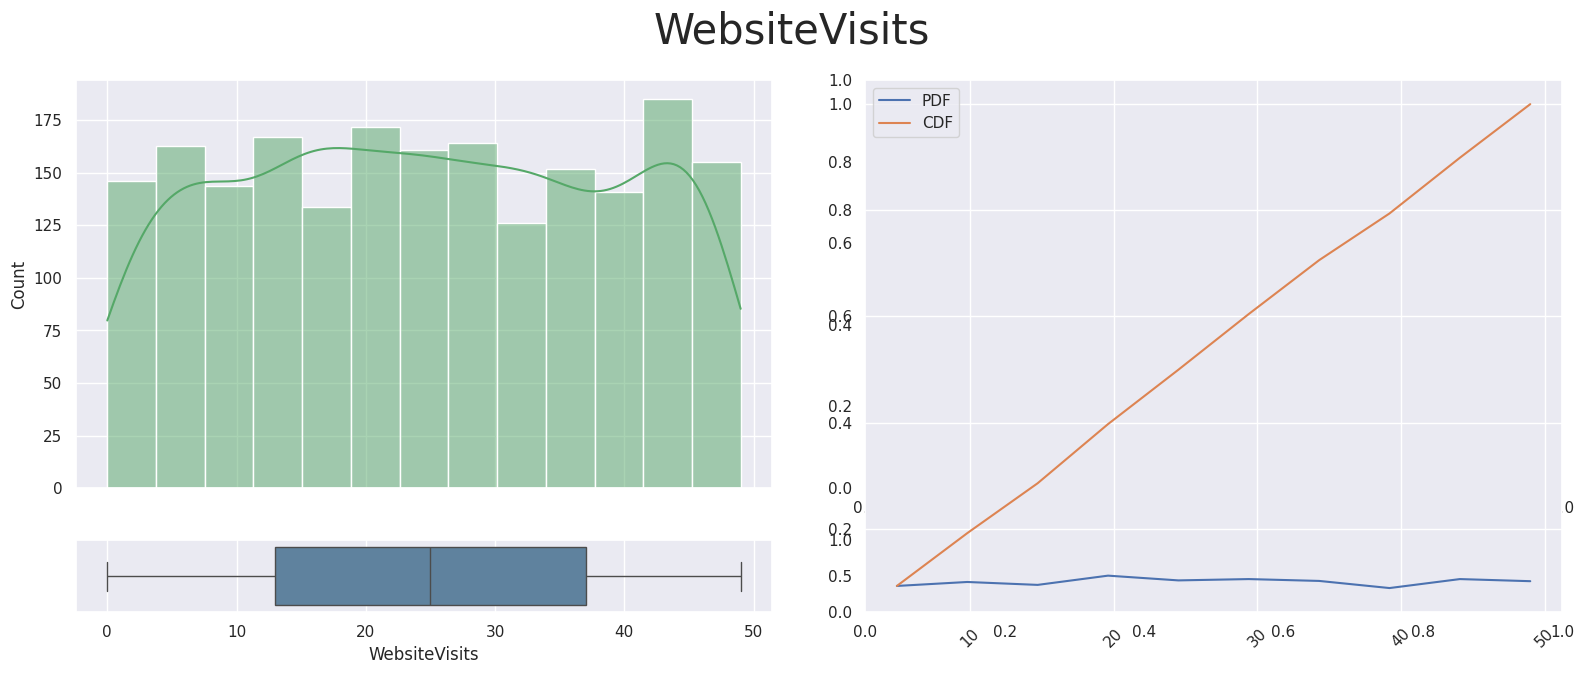

================== WebsiteVisits ==================
                             
count                  2010.0
mean                24.638806
std                 14.275219
min                       0.0
25%                      13.0
50%                      25.0
75%                      37.0
max                      49.0
shapiro               0.00000
normal                  False
missing                     0
skew                  0.00219
type     right(positive)-skew


In [16]:
describe_numerical_col(df, 'WebsiteVisits')

توی این ستون داده ها نرمال نیست و در بازه صفر و 49 بازدید از سایت هستند.

نرمال نیست اما به صورت یک نواخت پخش شده ند

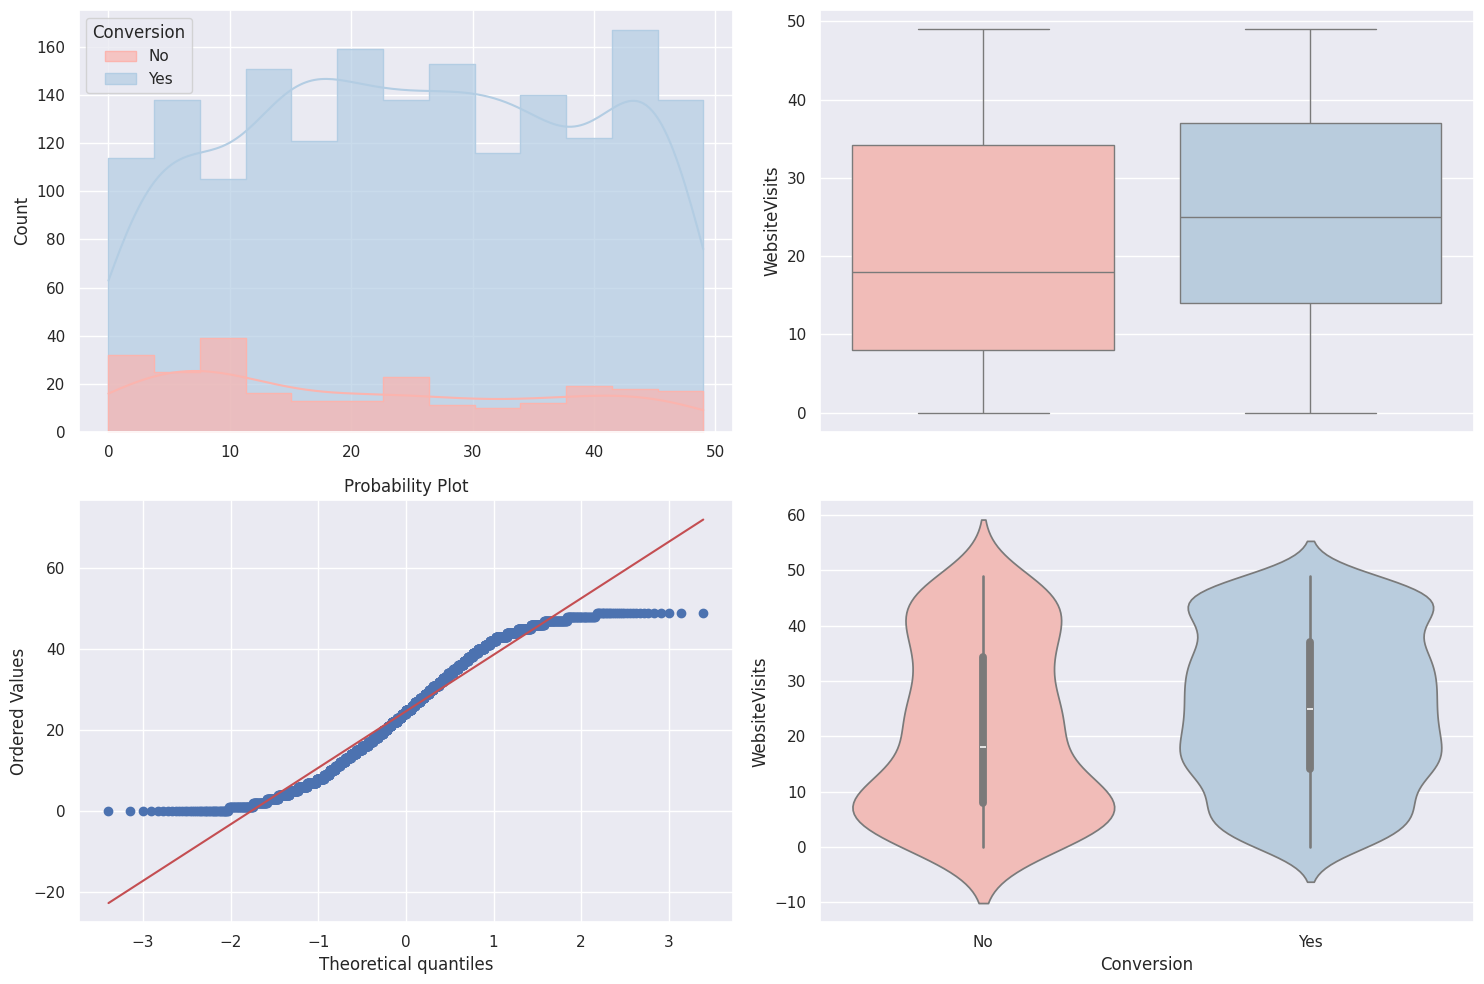

In [17]:
plot_numerical_vs_target(df, 'WebsiteVisits', 'Conversion')

تفاوت میانگین ها معلوم است

In [43]:
bins=[0, 25, 50]
bin_labels = ['Low', 'High']
df = categorize_numerical_col(df, 'WebsiteVisits', bins=bins, bins_name=bin_labels)

In [19]:
describe_categorical_col(df, 'WebsiteVisits_categorized')

================== WebsiteVisits_categorized ==================
  Group  Count     %
0   Low   1013  51.5
1  High    954  48.5


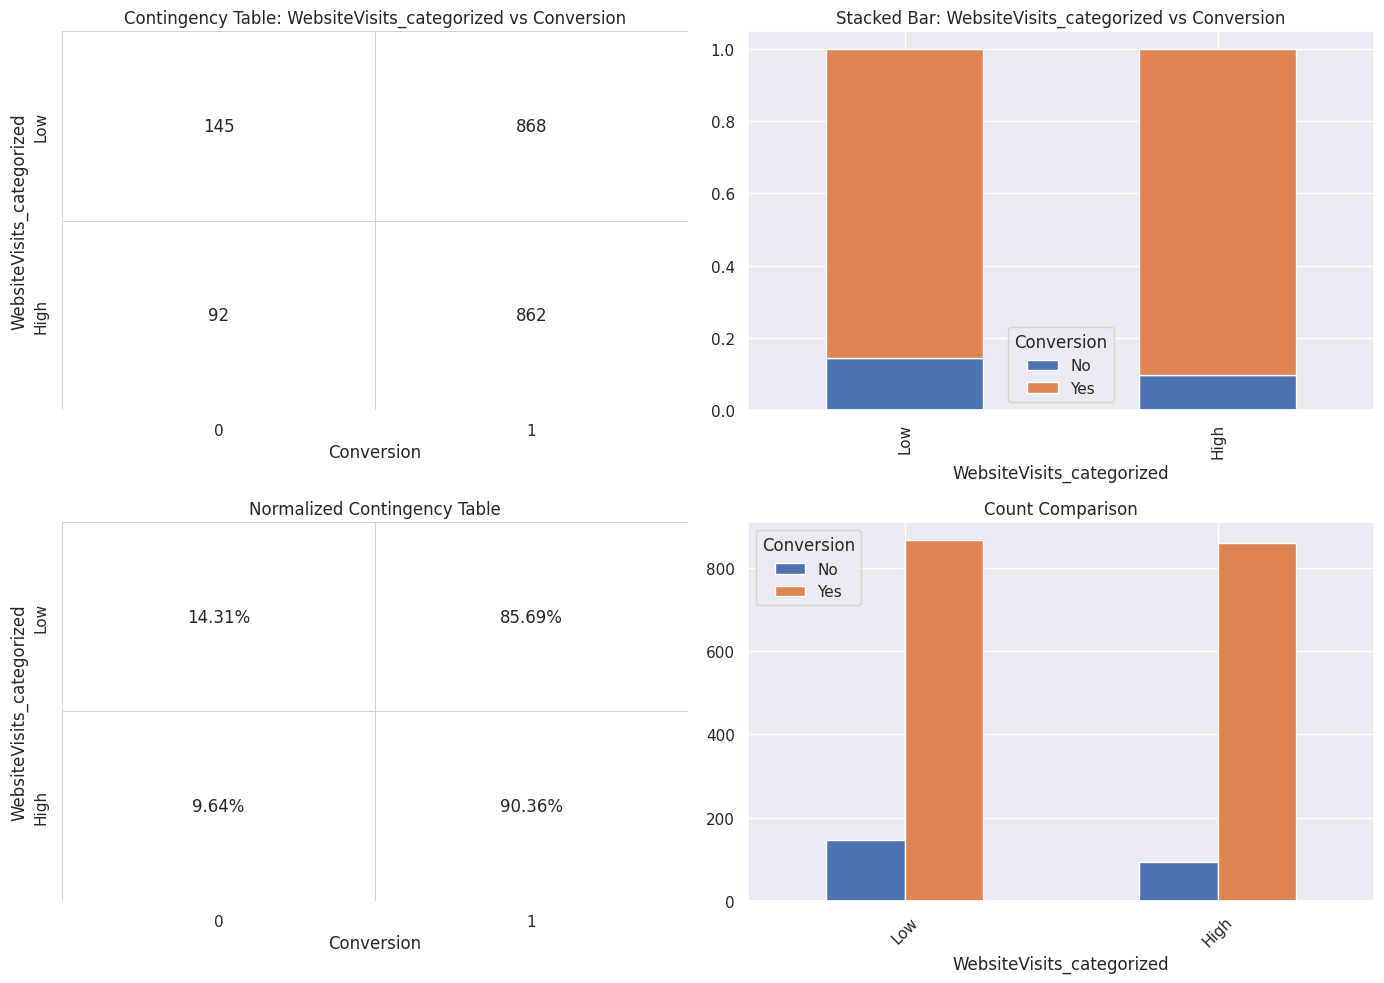

In [20]:
describe_cat_cat_relationship(df, 'WebsiteVisits_categorized', 'Conversion')

لیبل  high احتمال معناداری کمتری دارد و درصد تایید شده ها از بقیه کمتر است

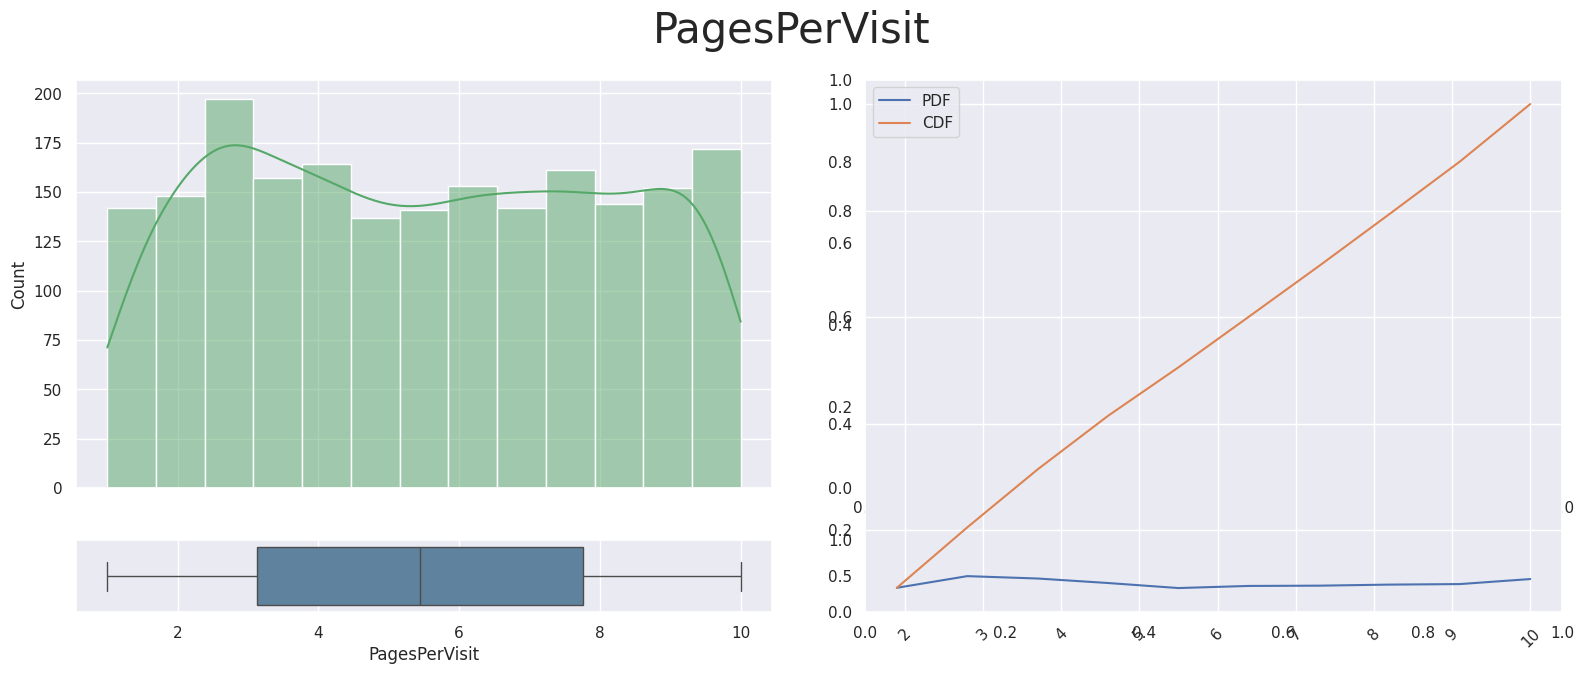

================== PagesPerVisit ==================
                             
count                  2010.0
mean                   5.4925
std                  2.620329
min                  1.001882
25%                  3.134389
50%                  5.446222
75%                  7.758085
max                  9.997134
shapiro               0.00000
normal                  False
missing                     0
skew                  0.04437
type     right(positive)-skew


In [21]:
describe_numerical_col(df, 'PagesPerVisit')

داده ها در بازه 0 تا 10 و با اینکه نرمال نیستند، پراکندگی یکنواخت دارد

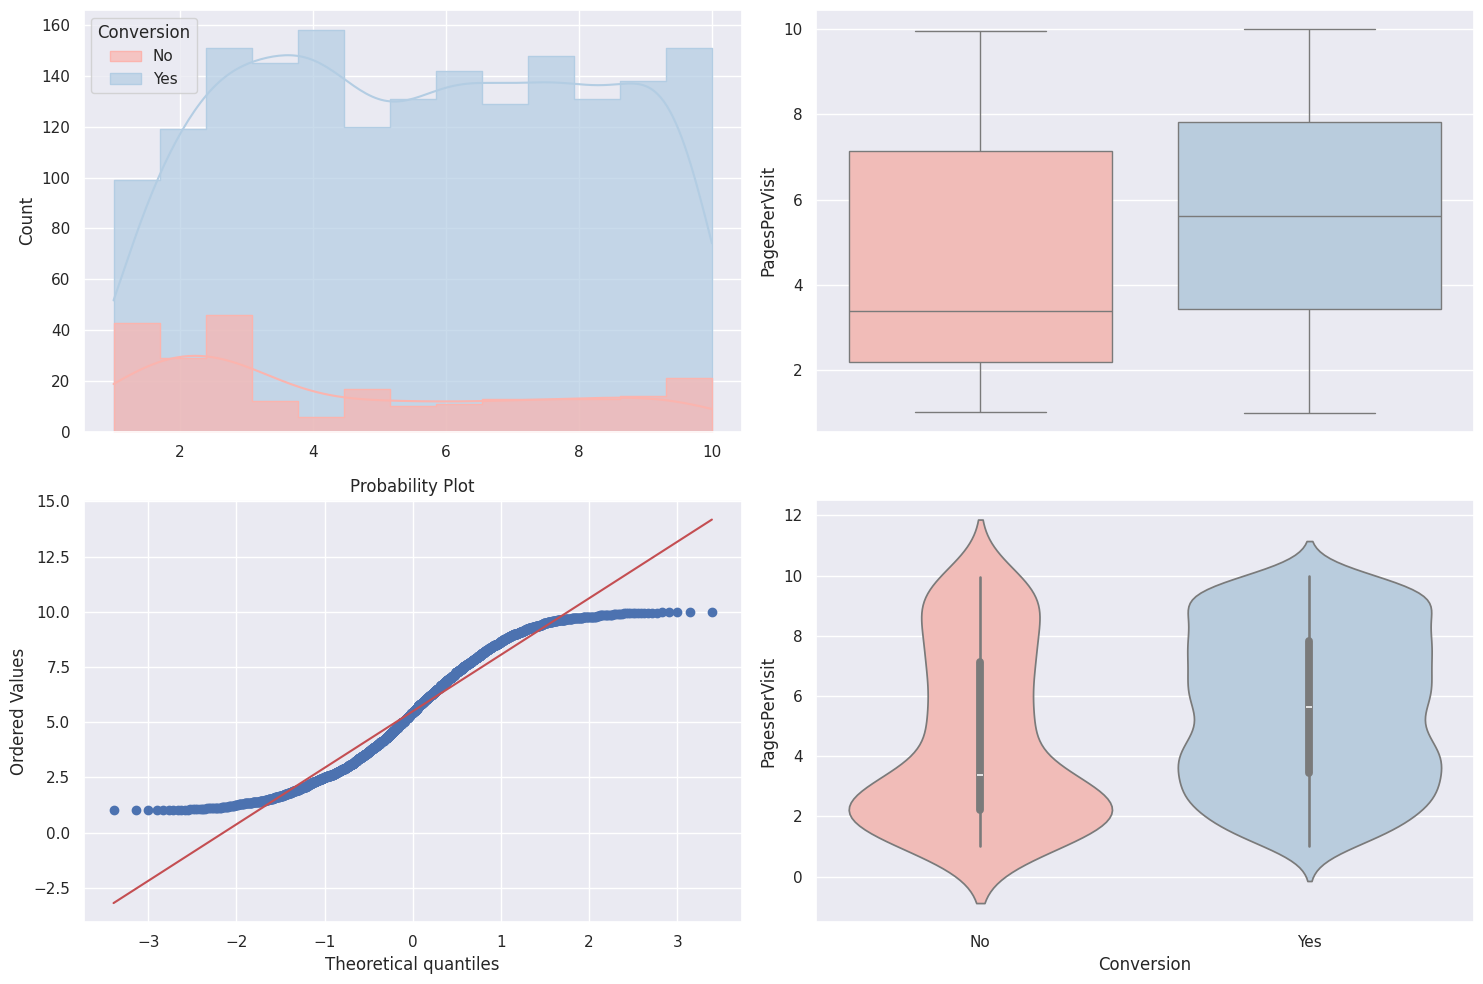

In [22]:
plot_numerical_vs_target(df, 'PagesPerVisit', 'Conversion')

تفاوت بین میانگین ها واضح است


In [50]:
bins=[0, 5, 10]
bin_labels = ['Low', 'High']
df = categorize_numerical_col(df, 'PagesPerVisit', bins=bins, bins_name=bin_labels)

In [28]:
describe_categorical_col(df, 'PagesPerVisit_categorized')

================== PagesPerVisit_categorized ==================
  Group  Count      %
0  High   1097  54.58
1   Low    913  45.42


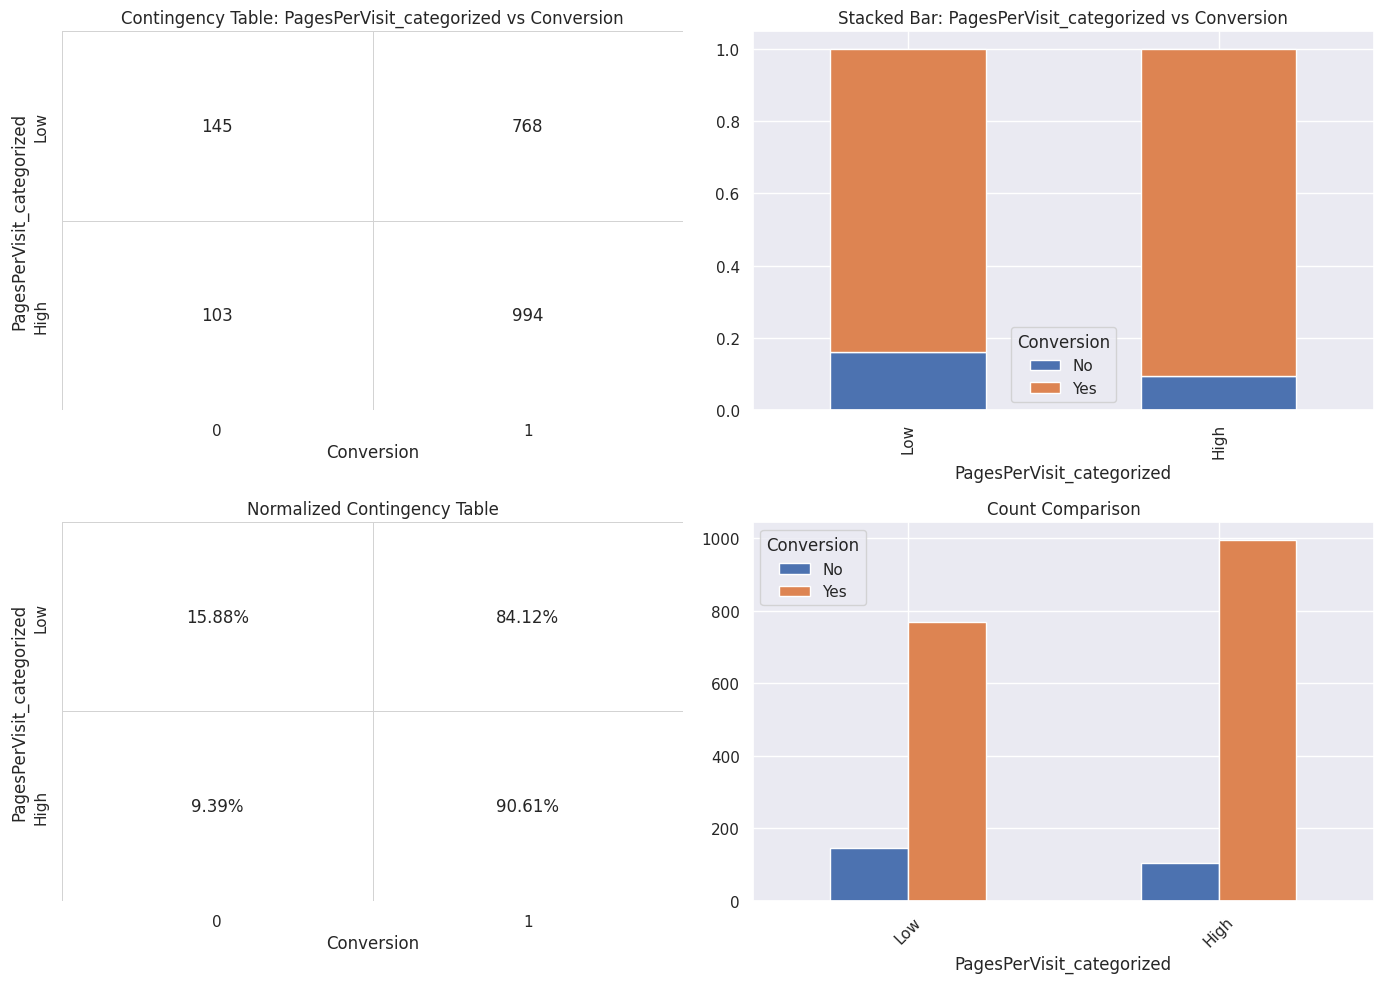

In [29]:
describe_cat_cat_relationship(df, 'PagesPerVisit_categorized', 'Conversion')

تفاوت تعداد high بیشتر است

In [30]:
df['TimeOnSite'].isna().sum()

np.int64(79)

Could be good with using groupby

In [31]:
df['TimeOnSite'] = df.groupby(['WebsiteVisits'])['TimeOnSite'].transform(
    lambda x: x.fillna(x.mean())
)

In [32]:
df['TimeOnSite'].isna().sum()

np.int64(0)

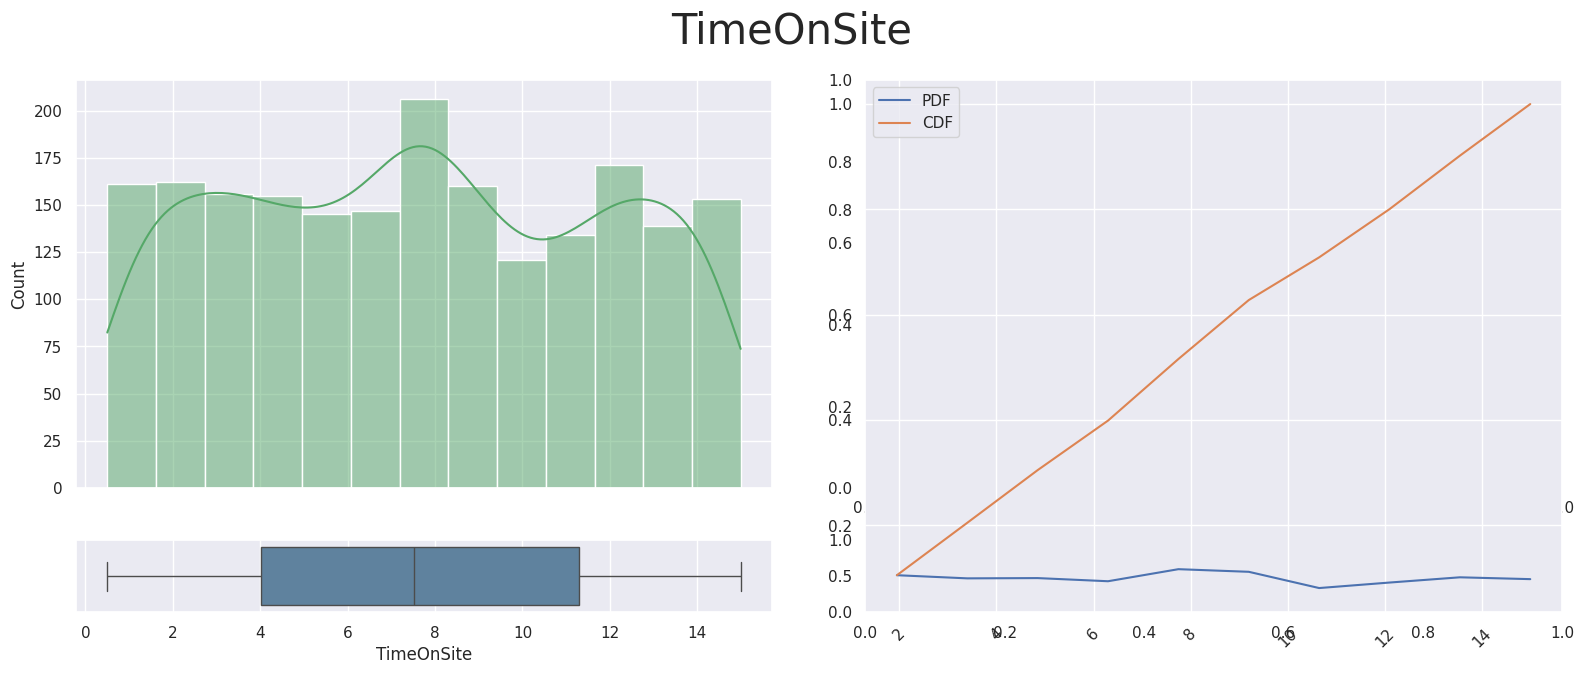

================== TimeOnSite ==================
                             
count                  2010.0
mean                 7.625291
std                   4.17212
min                  0.501684
25%                  4.020522
50%                  7.524956
75%                 11.296214
max                 14.992795
shapiro               0.00000
normal                  False
missing                     0
skew                  0.03547
type     right(positive)-skew


In [33]:
describe_numerical_col(df, 'TimeOnSite')

And Yet again not normal :)

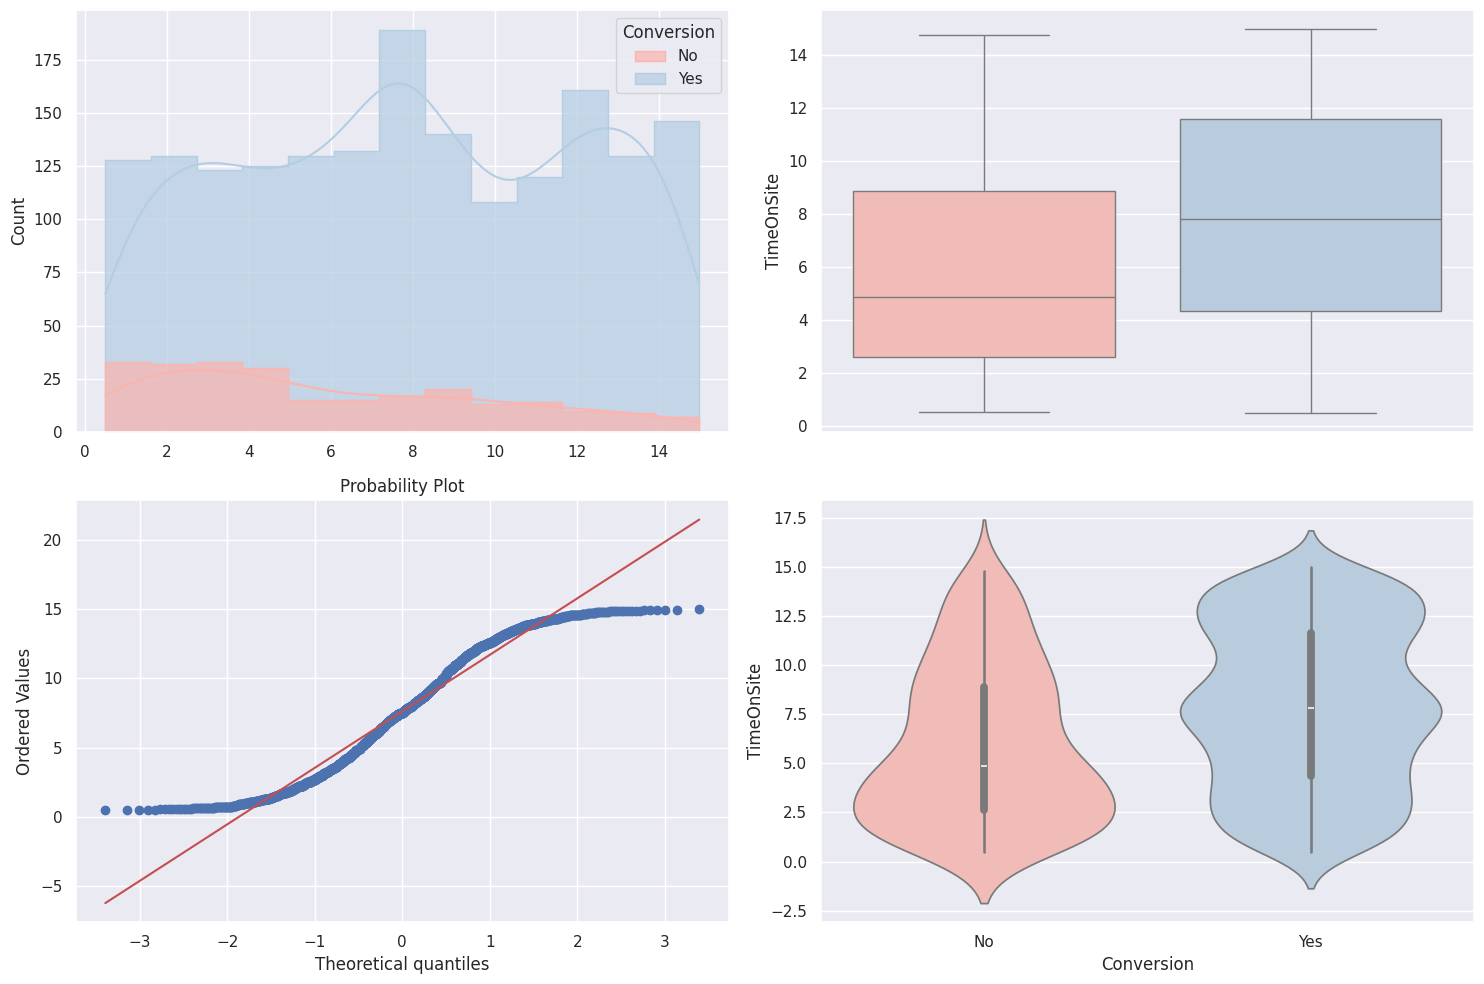

In [35]:
plot_numerical_vs_target(df, 'TimeOnSite', 'Conversion')

Means are for sure diffrent and the tests should be segnificant

In [46]:
bins=[0, 7, 15]
bin_labels = ['Low', 'High']
df = categorize_numerical_col(df, 'TimeOnSite', bins=bins, bins_name=bin_labels)

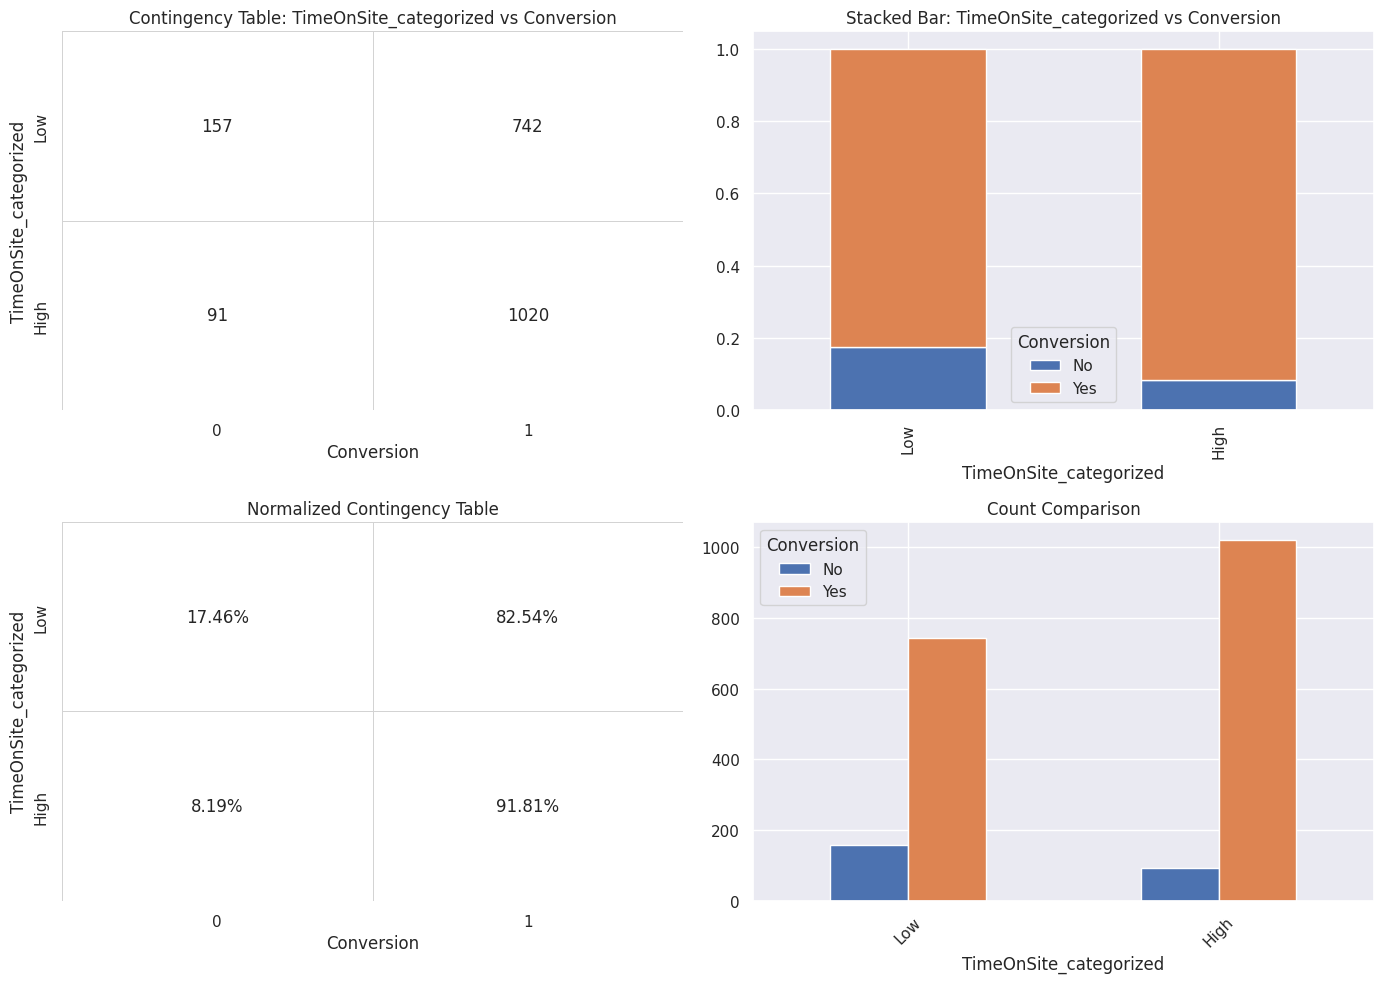

In [37]:
describe_cat_cat_relationship(df, 'TimeOnSite_categorized', 'Conversion')

Mid point could be from the mean nan replacement

In [40]:
droped_way = df.copy()
droped_way = droped_way.dropna(subset=['TimeOnSite'])

In [41]:
bins=[0, 7, 15]
bin_labels = ['Low', 'High']
droped_way = categorize_numerical_col(droped_way, 'TimeOnSite', bins=bins, bins_name=bin_labels)

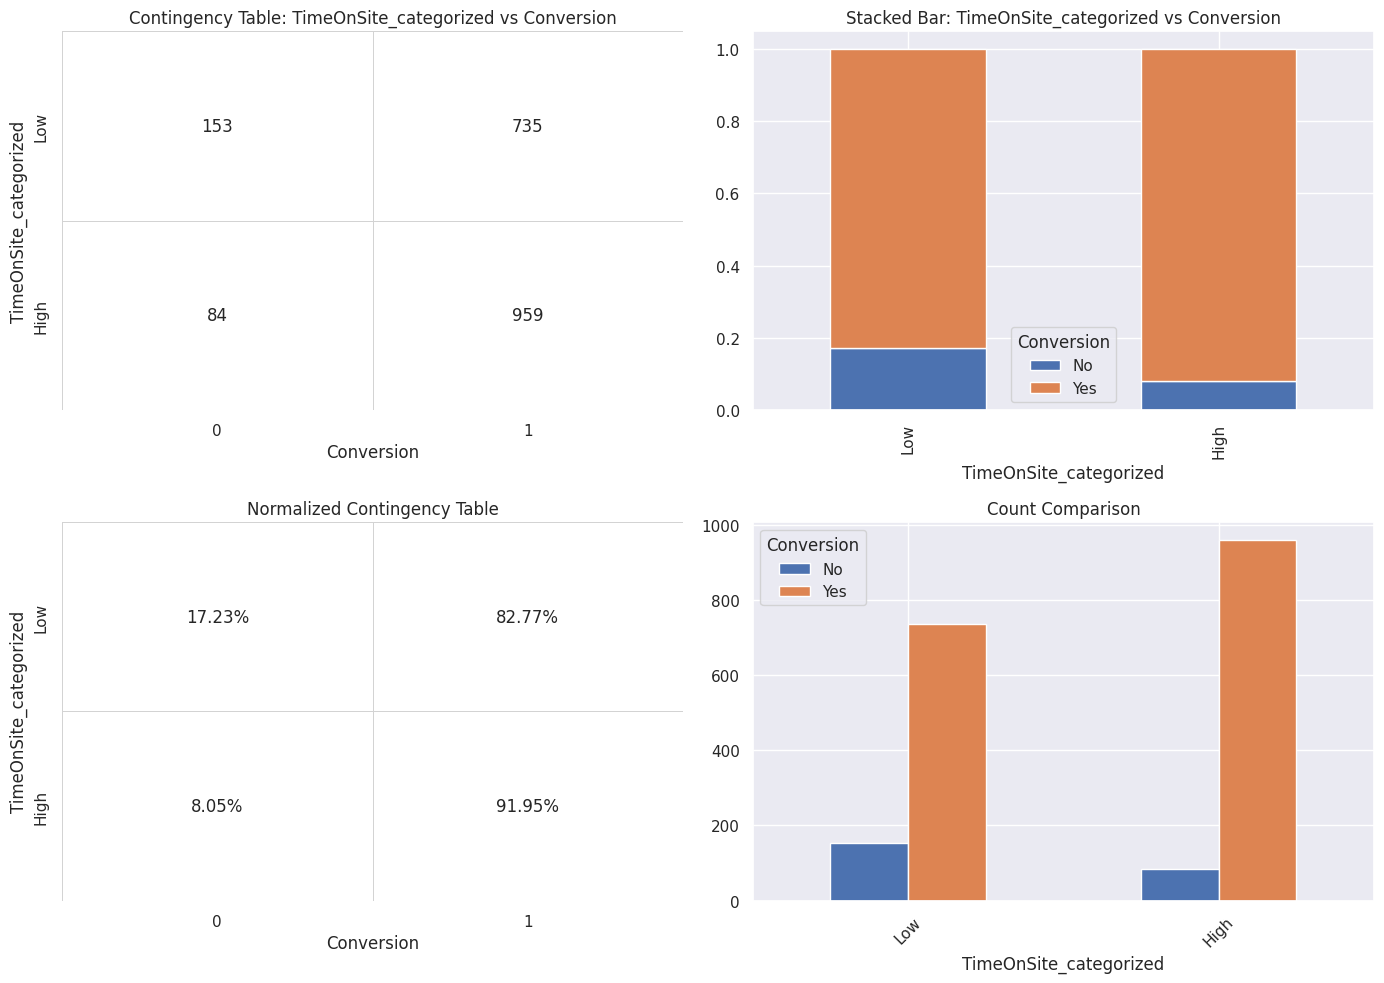

In [42]:
describe_cat_cat_relationship(droped_way, 'TimeOnSite_categorized', 'Conversion')

Maybbe it's not! It mostly is the same

<H1>Statistic tests

In [44]:
group0 = df[df["WebsiteVisits_categorized"] == 'Low']["Conversion"].values
group1 = df[df["WebsiteVisits_categorized"] == 'High']["Conversion"].values

numeric_nonparm_test('two-independent', group0, group1)

{
   "test type": "two-independent",
   "test": "Man-Whitney-U",
   "statistic": 460634.0,
   "p-value": 0.0014771209078904993,
   "decision": "Rejected"
}


Yes this HAS the significance between the high amount of website visits vs low

In [48]:
group0 = df[df["TimeOnSite_categorized"] == 'Low']["Conversion"].values
group1 = df[df["TimeOnSite_categorized"] == 'High']["Conversion"].values

numeric_nonparm_test('two-independent', group1, group0)

{
   "test type": "two-independent",
   "test": "Man-Whitney-U",
   "statistic": 505585.5,
   "p-value": 9.197391772904519e-10,
   "decision": "Rejected"
}


Well the time does also have the significance could be due to the nan data tho


In [49]:
group0 = droped_way[droped_way["TimeOnSite_categorized"] == 'Low']["Conversion"].values
group1 = droped_way[droped_way["TimeOnSite_categorized"] == 'High']["Conversion"].values

numeric_nonparm_test('two-independent', group1, group0)

{
   "test type": "two-independent",
   "test": "Man-Whitney-U",
   "statistic": 505585.5,
   "p-value": 9.197391772904519e-10,
   "decision": "Rejected"
}


Still it dosen't but the over all power got better

In [52]:
group0 = df[df["PagesPerVisit_categorized"] == 'Low']["Conversion"].values
group1 = df[df["PagesPerVisit_categorized"] == 'High']["Conversion"].values

numeric_nonparm_test('two-independent', group1, group0)

{
   "test type": "two-independent",
   "test": "Man-Whitney-U",
   "statistic": 533293.5,
   "p-value": 1.0550247813117832e-05,
   "decision": "Rejected"
}


Also had the significant nessesary! the Higher Pages visited improved the Conversion

